<a href="https://colab.research.google.com/github/JoseVL92/KillCaptcha/blob/main/ResNet_Character_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This cell imports the drive library and mounts Google Drive as a VM local drive. You can access to your Drive files 
# using this path "/content/gdrive/My Drive/"
 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Create a link to captchas directory
!ln -s /content/gdrive/My\ Drive/MachineLearning/DatasetsAndModels/CAPTCHAS/ /
!ls -al /CAPTCHAS/lenet

total 746546
-rw------- 1 root root 297610439 Nov 19 17:50 dataset_48x48.tar.gz
-rw------- 1 root root 466851373 Nov 18 15:37 dataset.tar.gz


In [ ]:
%cd /CAPTCHAS/lenet
# Download dataset from mediafire if not downloaded yet... ONLY ONCE
# This link is frecuently updated from
# https://www.mediafire.com/file/1d6q46gstpdzl2m/dataset_48x48.tar.gz/file
 
!wget https://download1581.mediafire.com/ie7pc7kmmb9g/1d6q46gstpdzl2m/dataset_48x48.tar.gz

/content/gdrive/My Drive/MachineLearning/DatasetsAndModels/CAPTCHAS/lenet
--2020-11-19 17:50:39--  https://download1581.mediafire.com/ie7pc7kmmb9g/1d6q46gstpdzl2m/dataset_48x48.tar.gz
Resolving download1581.mediafire.com (download1581.mediafire.com)... 199.91.152.81
Connecting to download1581.mediafire.com (download1581.mediafire.com)|199.91.152.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 297610439 (284M) [application/x-gzip]
Saving to: ‘dataset_48x48.tar.gz’

dataset_48x48.tar.g 100%[===================>] 283.82M  11.9MB/s    in 27s     

2020-11-19 17:51:06 (10.7 MB/s) - ‘dataset_48x48.tar.gz’ saved [297610439/297610439]



In [3]:
# Copy dataset to VM
!mkdir -p /lenet
!cp /CAPTCHAS/lenet/dataset_48x48.tar.gz /lenet/dataset.tar.gz

In [4]:
# Decompress dataset
%cd /lenet
!tar -xf dataset.tar.gz
!ls -al /lenet/

/lenet
total 290652
drwxr-xr-x  3 root root      4096 Nov 21 15:44 .
drwxr-xr-x  1 root root      4096 Nov 21 15:43 ..
drwxrwxr-x 67 1000 1000      4096 Nov 19 17:33 dataset
-rw-------  1 root root 297610439 Nov 21 15:44 dataset.tar.gz


In [ ]:
# Ensure all dependencies are installed
#!pip3 install scikit-learn
#!pip3 install tensorflow
#!pip3 install imutils
#!pip3 install matplotlib
#!pip3 install opencv-python

In [ ]:
# Implement Lenet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
 
 
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        input_shape = (height, width, depth)
 
        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            input_shape = (depth, height, width)
 
        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",
                         input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
 
        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
 
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))
 
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
 
        # return the constructed network architecture
        return model

In [5]:
# Implement ResNet
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
 
 
class ResNet:
    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False,
                       reg=0.0001, bnEps=2e-5, bnMom=0.9):
        # the shortcut branch of the ResNet module should be
        # initialize as the input (identity) data
        shortcut = data
 
        # the first block of the ResNet module are the 1x1 CONVs
        bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                 momentum=bnMom)(data)
        act1 = Activation("relu")(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
                       kernel_regularizer=l2(reg))(act1)
 
        # the second block of the ResNet module are the 3x3 CONVs
        bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                 momentum=bnMom)(conv1)
        act2 = Activation("relu")(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
                       padding="same", use_bias=False,
                       kernel_regularizer=l2(reg))(act2)
 
        # the third block of the ResNet module is another set of 1x1
        # CONVs
        bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                 momentum=bnMom)(conv2)
        act3 = Activation("relu")(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias=False,
                       kernel_regularizer=l2(reg))(act3)
 
        # if we are to reduce the spatial size, apply a CONV layer to
        # the shortcut
        if red:
            shortcut = Conv2D(K, (1, 1), strides=stride,
                              use_bias=False, kernel_regularizer=l2(reg))(act1)
 
        # add together the shortcut and the final CONV
        x = add([conv3, shortcut])
 
        # return the addition as the output of the ResNet module
        return x
 
    @staticmethod
    def build(width, height, depth, classes, stages, filters,
              reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1
 
        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
 
        # set the input and then apply a BN followed by CONV
        inputs = Input(shape=inputShape)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                               momentum=bnMom)(inputs)
        x = Conv2D(filters[0], (3, 3), use_bias=False,
                   padding="same", kernel_regularizer=l2(reg))(x)
 
        # loop over the number of stages
        for i in range(0, len(stages)):
            # initialize the stride, then apply a residual module
            # used to reduce the spatial size of the input volume
            stride = (1, 1) if i == 0 else (2, 2)
            x = ResNet.residual_module(x, filters[i + 1], stride, chanDim, 
                                       red=True, bnEps=bnEps, bnMom=bnMom)
 
            # loop over the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a ResNet module
                x = ResNet.residual_module(x, filters[i + 1], (1, 1),
                                           chanDim, bnEps=bnEps, bnMom=bnMom)
 
        # apply BN => ACT => POOL
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                               momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = AveragePooling2D((8, 8))(x)
 
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer=l2(reg))(x)
        x = Activation("softmax")(x)
 
        # create the model
        model = Model(inputs, x, name="resnet")
 
        # return the constructed network architecture
        return model

In [ ]:
# Define Batches
 
from imutils import paths
import string
import numpy as np
from sklearn.model_selection import train_test_split
 
classes = string.digits + string.ascii_uppercase + string.ascii_lowercase
 
# loop over the input images
# split images in batches (too much images, almost 200k 64x64)
b1 = []
b2 = []
# b3 = []
# b4 = []
# b5 = []
 
fixes_train = []
fixes_test = []
for character in "@$#":
    pathList = list(paths.list_images(f"/lenet/dataset/{character}"))
    train_, test_ = train_test_split(pathList, test_size=0.2, random_state=np.random)
    fixes_train.extend(train_)
    fixes_test.extend(test_)
 
for character in classes:
    pathList = list(paths.list_images(f"/lenet/dataset/{character}"))
    # batch1, residual = train_test_split(pathList, test_size=0.75, random_state=np.random)
    # batch1, residual = train_test_split(pathList, test_size=0.67, random_state=np.random)
    batch1, batch2 = train_test_split(pathList, test_size=0.5, random_state=np.random)
 
    #batch1 = batch1 if len(batch1) > 0 else [random.choice(pathList)]
    #batch2 = batch2 if len(batch2) > 0 else [random.choice(pathList)]
    #batch3 = batch3 if len(batch3) > 0 else [random.choice(pathList)]
    #batch4 = batch4 if len(batch4) > 0 else [random.choice(pathList)]
    # batch5 = batch5 if len(batch5) > 0 else [random.choice(pathList)]
 
 
 
    b1.extend(batch1)
    b2.extend(batch2)
    # b3.extend(batch3)
    # b4.extend(batch4)
    # b5.extend(batch5)
 
total_images = len(list(paths.list_images("/lenet/dataset")))
 
print(f"[INFO] total images: {total_images}")
print(f"[INFO] batch1: {len(b1)}")
print(f"[INFO] batch2: {len(b2)}")
# print(f"[INFO] batch3: {len(b3)}")
# print(f"[INFO] batch4: {len(b4)}")
print(f"[INFO] fixes train: {len(fixes_train)}")
print(f"[INFO] fixes test: {len(fixes_test)}")
# print(f"[INFO] batch5: {len(b5)}")
 
# free some memory
del pathList
del batch1
del batch2
# del batch3
# del batch4
del train_
del test_
# del batch5
 
del b1
del b2

[INFO] total images: 197863
[INFO] batch1: 98904
[INFO] batch2: 98933
[INFO] fixes train: 19
[INFO] fixes test: 7


In [6]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
 
 
EPOCHS = 100
INIT_LR = 1e-1  # 1e-1 = 0.1
BS = 64
 
# Get always present arrays for less common classes
#data_fixed_train = []
#labels_fixed_train = []
#data_fixed_test = []
#labels_fixed_test = []
#for imagePath in fixes_train:
        # load the image, pre-process it, and store it in the data list
        # image = cv2.imread(imagePath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # image = img_to_array(image)
        # data_fixed_train.append(image)
 
        # extract the class label from the image path and update the
        # labels list
        # label = imagePath.split(os.path.sep)[-2]
        # labels_fixed_train.append(label)
# for imagePath in fixes_test:
        # load the image, pre-process it, and store it in the data list
        # image = cv2.imread(imagePath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # image = img_to_array(image)
        # data_fixed_test.append(image)
 
        # extract the class label from the image path and update the
        # labels list
        # label = imagePath.split(os.path.sep)[-2]
        # labels_fixed_test.append(label)
 
 
# Initialize and compile the model
print("[INFO] compiling model...")
# model = LeNet.build(width=48, height=48, depth=1, classes=65)
model = ResNet.build(width=48, height=48, depth=1, classes=65, stages=(3, 3, 3), filters=(64, 64, 128, 256), reg=0.0005)
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
 
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=10,
                         zoom_range=0.05,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.15,
                         horizontal_flip=False,
                         fill_mode="nearest")
 
# Iterate over batches
# for index, b in enumerate((b1, b2)):
data = []
labels = []
for imagePath in paths.list_images("/lenet/dataset"):
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = img_to_array(image)
    data.append(image)
 
    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
 
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
print("[INFO] splitting in train-test...")
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels, test_size=0.2, random_state=np.random)
#trainX += data_fixed_train
#trainY += labels_fixed_train
#testX += data_fixed_test
#testY += labels_fixed_test
 
print("[INFO] scaling to range 0-1...")
# scale the raw pixel intensities to the range [0, 1]
trainX = np.array(trainX, dtype="float") / 255.0
testX = np.array(testX, dtype="float") / 255.0
trainY = np.array(trainY)
testY = np.array(testY)
 
print("[INFO] vectorizing labels...")
# convert the labels from strings to vectors
# if index == 0:
lb = LabelBinarizer().fit(trainY)
trainY = lb.transform(trainY)
testY = lb.transform(testY)
 
# train the network
print("[INFO] training network...")
es_callback = EarlyStopping(monitor='val_loss', patience=4)
# H = model.fit(trainX, trainY, validation_data=(testX, testY),
#               batch_size=64, epochs=EPOCHS, verbose=1, callbacks=[es_callback])
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    batch_size=BS,
    epochs=EPOCHS,
    verbose=1, 
    callbacks=[es_callback]
)
 
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
                        predictions.argmax(axis=1), target_names=lb.classes_))  # , labels=lb.classes_, target_names=lb.classes_))
 
# save the model to disk
print("[INFO] serializing network...")
model.save("/CAPTCHAS/lenet/resnet.hdf5")

[INFO] compiling model...
[INFO] splitting in train-test...
[INFO] scaling to range 0-1...
[INFO] vectorizing labels...
[INFO] training network...
Epoch 1/100
2474/2474 [==============================] - 182s 74ms/step - loss: 1.6649 - accuracy: 0.6433 - val_loss: 0.8735 - val_accuracy: 0.8346
Epoch 2/100
2474/2474 [==============================] - 181s 73ms/step - loss: 0.7979 - accuracy: 0.8567 - val_loss: 0.6319 - val_accuracy: 0.8984
Epoch 3/100
2474/2474 [==============================] - 181s 73ms/step - loss: 0.6593 - accuracy: 0.8913 - val_loss: 0.5609 - val_accuracy: 0.9152
Epoch 4/100
2474/2474 [==============================] - 181s 73ms/step - loss: 0.5943 - accuracy: 0.9082 - val_loss: 0.5086 - val_accuracy: 0.9284
Epoch 5/100
2474/2474 [==============================] - 181s 73ms/step - loss: 0.5566 - accuracy: 0.9179 - val_loss: 0.4843 - val_accuracy: 0.9370
Epoch 6/100
2474/2474 [==============================] - 181s 73ms/step - loss: 0.5302 - accuracy: 0.9253 - val_l

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           #       0.00      0.00      0.00         1
           $       0.00      0.00      0.00         1
           0       0.97      0.99      0.98       977
           1       0.94      0.97      0.96      1094
           2       0.99      0.99      0.99      2094
           3       0.98      0.99      0.99      2175
           4       0.99      0.99      0.99      2101
           5       0.99      0.99      0.99      2026
           6       0.98      0.99      0.99      1773
           7       0.99      0.99      0.99      1997
           8       0.99      0.99      0.99      2162
           9       0.98      0.98      0.98      1055
           @       0.00      0.00      0.00         1
           A       0.96      0.95      0.96       396
           B       0.90      0.92      0.91       339
           C       0.88      0.94      0.91       351
           D       0.95      0.96      0.96       339
           E       0.86    

In [8]:
# saving labels
print("[INFO] serializing labels...")
classes_ = list(lb.classes_)
classes_json = {str(index): classes_[index] for index in range(len(classes_))}
with open("/CAPTCHAS/lenet/classes.json", "w") as classes_file:
    json.dump(classes_json, classes_file)

[INFO] serializing labels...


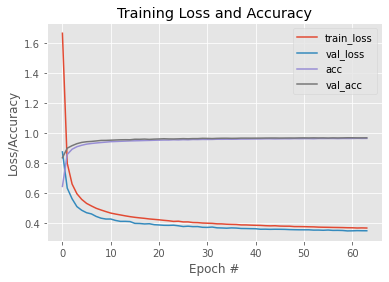

In [9]:
# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 64), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 64), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 64), H.history["accuracy"], label="acc")
plt.plot(np.arange(0, 64), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()